Title: Gradient Filters and Edge Detection
Author: Thomas M. Breuel
Institution: UniKL

Gradient Filters
================

In [111]:

from scipy.ndimage import filters,measurements
from scipy import stats
def ims(image,**kw):
    size = kw.get("s",8)
    if "s" in kw: del kw["s"]
    subplots(1,1,figsize=(size,size))
    gray(); imshow(image,**kw)
def imp(image,**kw):
    subplots(1,1,figsize=(6,6))
    gray(); imshow(image,interpolation='nearest',**kw)
def imrow(*args,**kw):
    gray()
    size = kw.get("s",8)
    if "s" in kw: del kw["s"]
    n = len(args)
    subplots(1,n,figsize=(n*size,size))
    for i,im in enumerate(args):
        subplot(1,n,i+1); imshow(im,**kw)
def rescale(image):
    return (image-amin(image))/max(1e-4,amax(image)-amin(image))

In [33]:
image = mean(imread("bridge.jpg")/255.0,axis=2)
test = mean(imread("testimage.jpg")/255.0,axis=2)
impulse = zeros((64,64))
impulse[32,32] = 1.0

A second class of filters that is very important is gradient or derivative filters.

Unlike smoothing filters or averaging filters, derivative filters "reveal more structure" in the image.

The simplest derivative filter is a computation of differences between neighboring pixels.

Note that we are looking both at differences and the absolute value of the difference.

The difference images are mostly gray because the display function rescales everything
so that negative values are black, positive values are white, and zero is gray (in between).

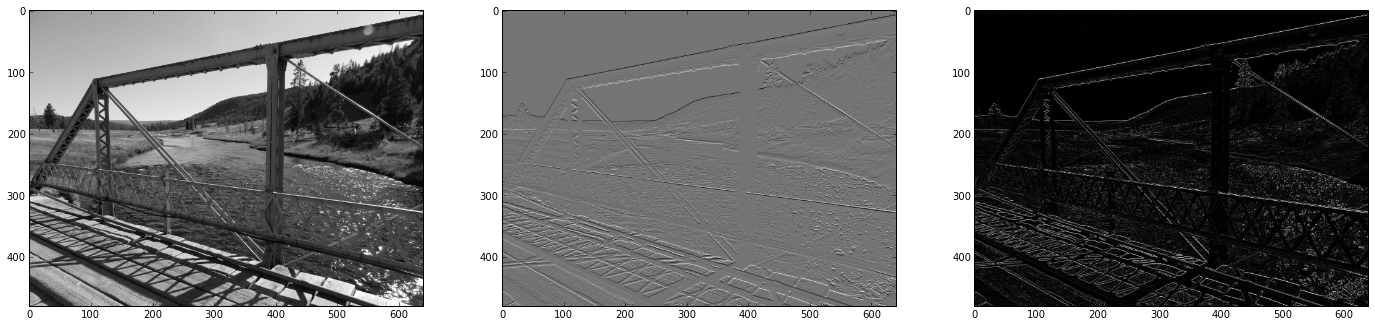

In [34]:
delta = image-roll(image,1,axis=0)
imrow(image,delta,abs(delta))

Let's look at the test image.  This shows a bit more clearly what is going on.

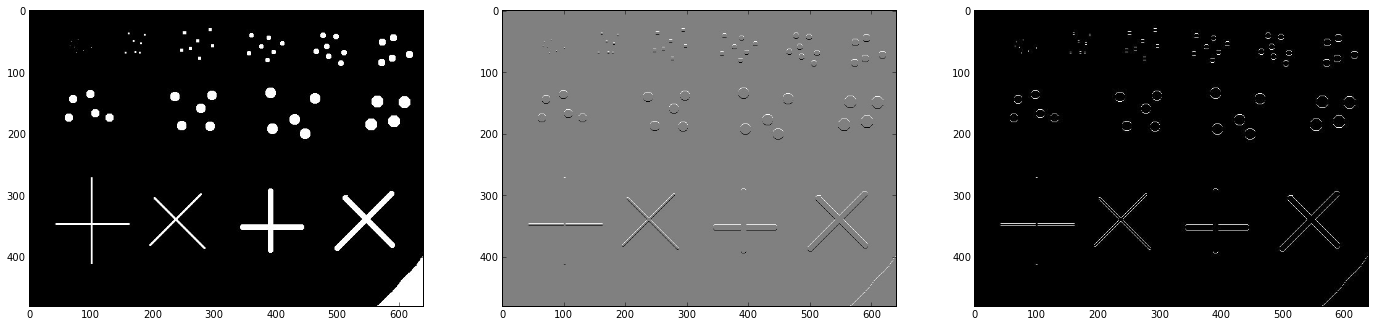

In [35]:
delta = test-roll(test,1,axis=0)
imrow(test,delta,abs(delta))

These are linear filters, so we can look at the impulse response.

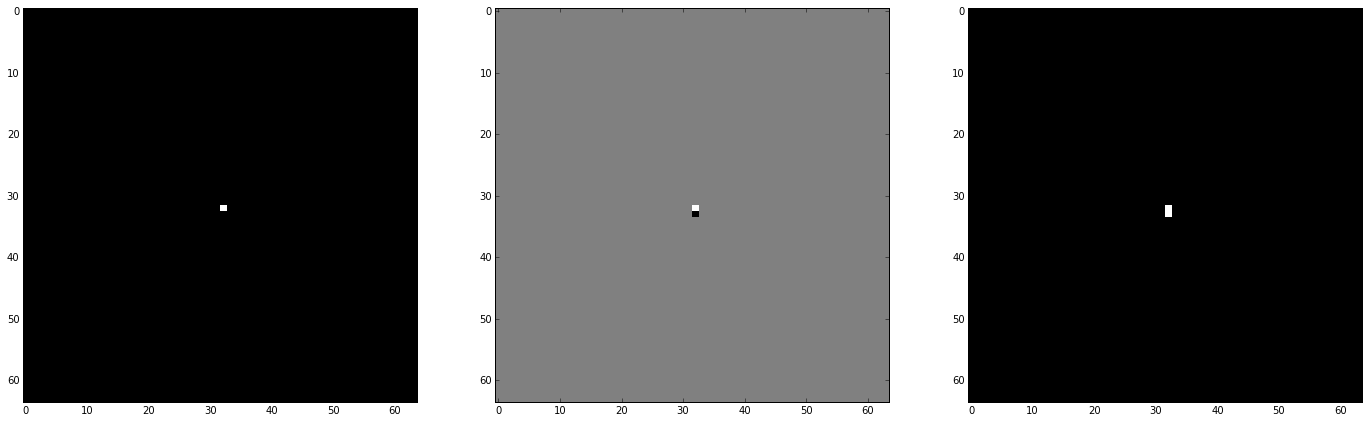

In [36]:
delta = impulse-roll(impulse,1,axis=0)
imrow(impulse,delta,abs(delta),interpolation='nearest')

There are a number of predefined derivative filters in the library, Prewitt, Sobel, and Gaussian derivatives.

All of these are really just compositions of a simple derivative filter and a smoothing filter.

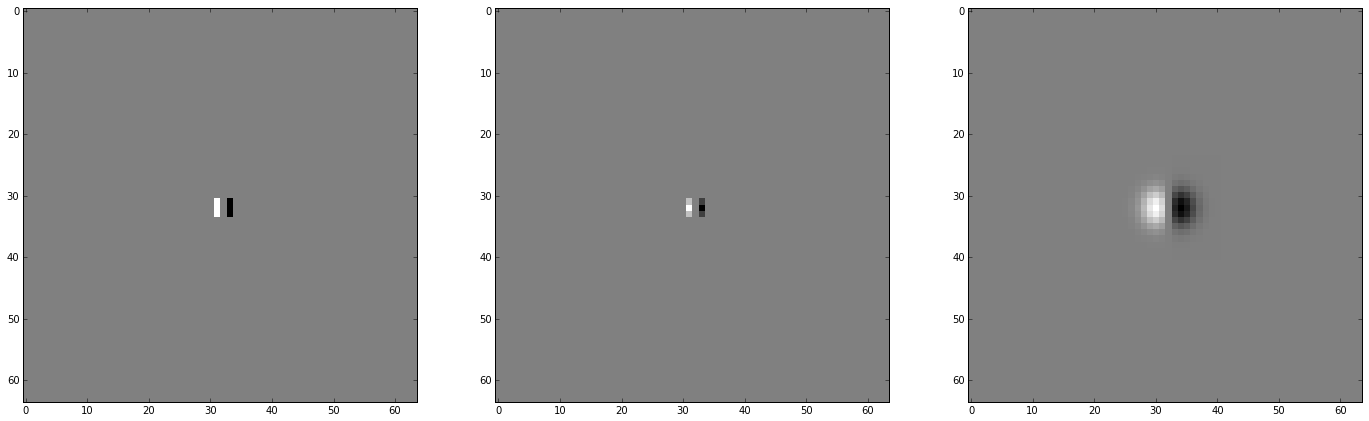

In [37]:
imrow(filters.prewitt(impulse),
      filters.sobel(impulse),
      filters.gaussian_filter(impulse,2.0,order=(0,1)),
      interpolation='nearest')

Of these, the Gaussian derivative filter is the most useful (the others are fast but not very good).

Let's look at this on a real image.

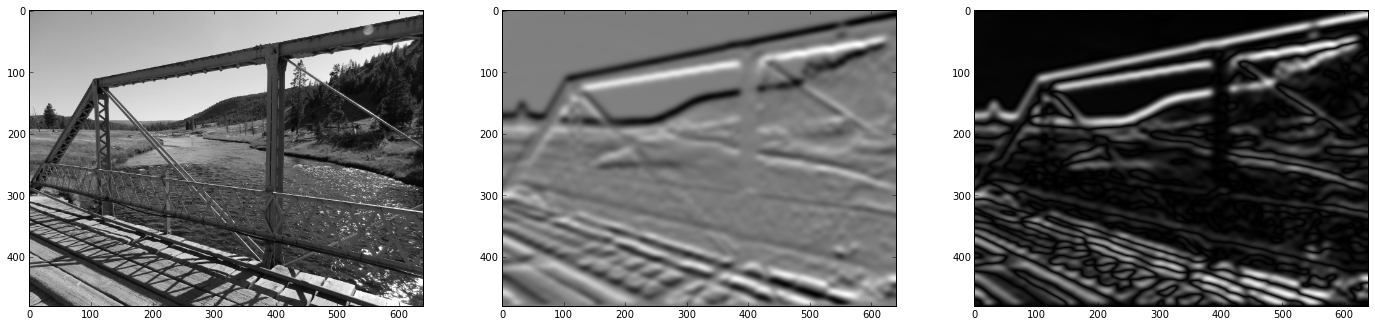

In [38]:
deriv = filters.gaussian_filter(image,5.0,order=(1,0))
imrow(image,deriv,abs(deriv))

Note that these are directional derivatives (vertical in this case).  We'll return to this in a second.

Idealized Step Edge
-------------------

We understood smoothing as "averaging to get rid of noise".

We can understand derivative filters as detectors for idealized step edges.

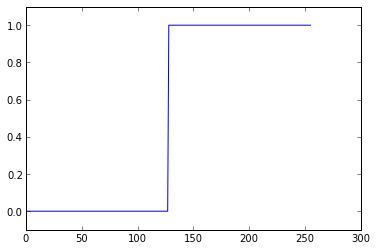

In [39]:
step = zeros(256); step[128:] = 1.0
ylim(-0.1,1.1)
plot(step)

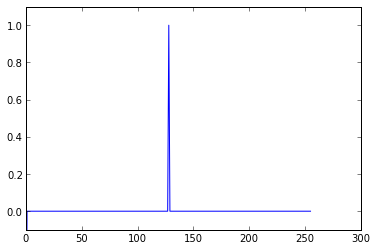

In [40]:
ylim(-0.1,1.1)
plot(step-roll(step,1))

Real-world signals are noisy.  How does this work here?

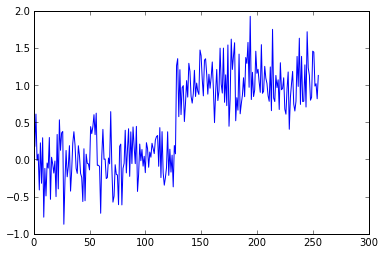

In [41]:
nstep = step + 0.3*randn(*step.shape)
plot(nstep)

On the noisy signal, it is hard to identify the step edge.

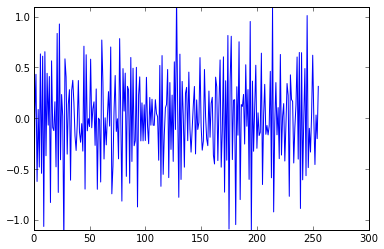

In [42]:
ylim(-1.1,1.1)
plot(nstep-roll(nstep,1))

We can now combine derivative filters and smooth the result.

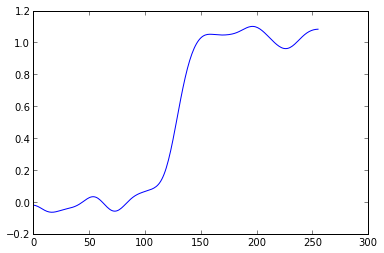

In [43]:
gnstep = filters.gaussian_filter(nstep,10.0)
plot(gnstep)

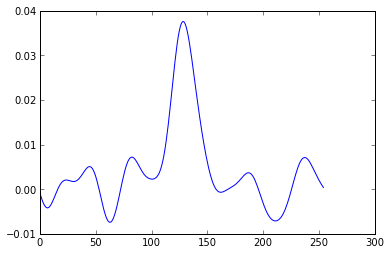

In [44]:
plot((gnstep-roll(gnstep,1))[1:])

Gradient Magnitude
------------------

We have seen step edge detection in 1D and derivative filters in 2D.  How does that all fit together?

We can understand that if we view the grayscale image as an intensity surface.  

We are computing _gradients_ on this surface.

If the surface was continuous, we are interested in partial derivatives of the form:

$(\frac{\partial I}{\partial x},\frac{\partial I}{\partial y})$

These partial derivatives themselves form vectors.

(0.0, 1.0)

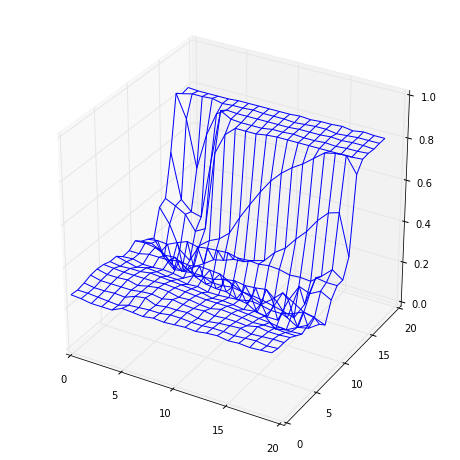

In [74]:
from mpl_toolkits.mplot3d import Axes3D
subplots(1,1,figsize=(8,8))
n = 20
x,y = meshgrid(range(n),range(n))
z = image[100:100+n,200:200+n]
ax = gcf().add_subplot(111,projection='3d')
ax.plot_wireframe(x,y,z)
ax.set_zlim3d(0.0,1.0)

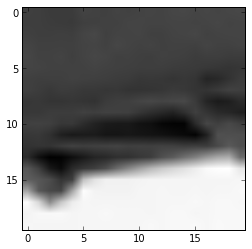

In [75]:
imshow(z)

We approximate the vector of partial derivatives with the filters that we compute.

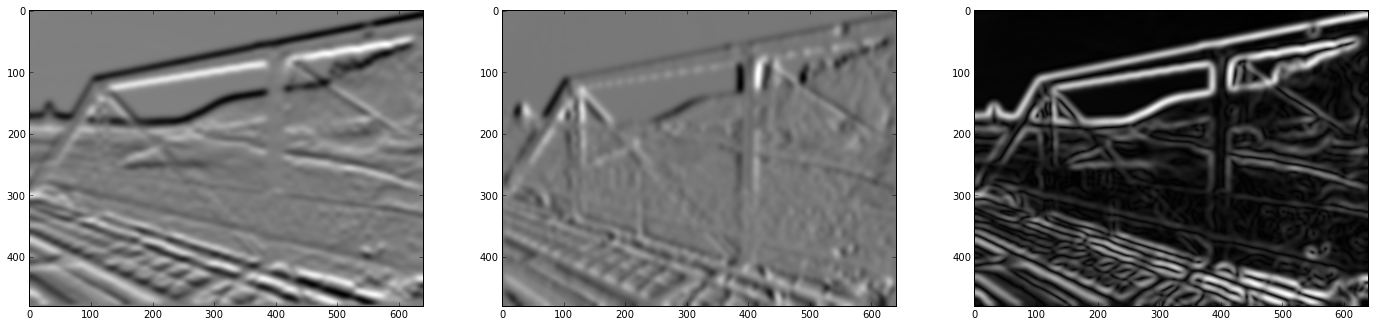

In [46]:
d0 = filters.gaussian_filter(image,5.0,order=(1,0))
d1 = filters.gaussian_filter(image,5.0,order=(0,1))
mag = sqrt(d0**2+d1**2)
imrow(d0,d1,mag)

Why do we use the 2-norm for computing the absolute magnitude of these estimates of derivative vectors?

Because the 1-norm is not rotation invariant, so we get artifacts.

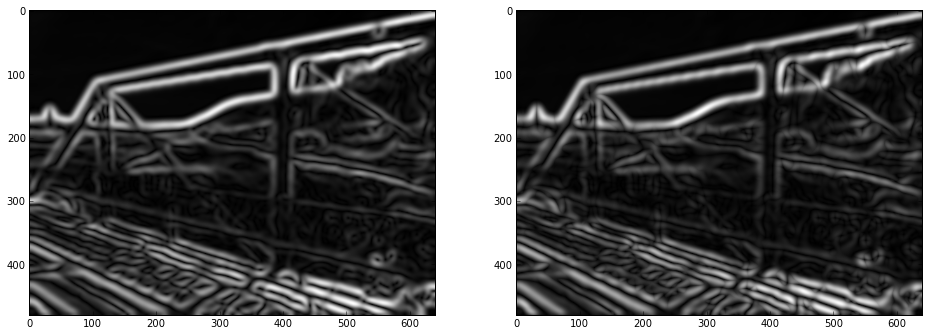

In [47]:
imrow(mag,abs(d0)+abs(d1))

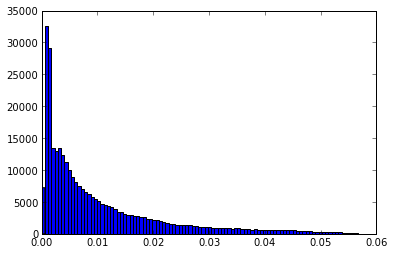

In [48]:
_=hist(mag.ravel(),bins=100)

# Edge Detection 

Edge detection is the process of identifying the location of the underlying edge.

From the 1D step edge example, we find that a good estimator for the location of the step edge is the maximum of the derivative.

In the 2D case, we can try to find this by _non-maximum suppression_; that is, we perform maximum detection in multiple directions.

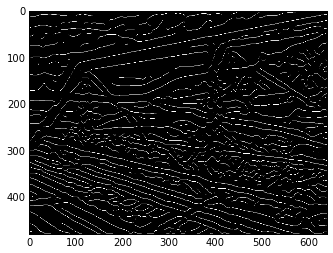

In [51]:
imshow((mag>roll(mag,-1,0))*(mag>roll(mag,1,0)))

In [109]:
def roll2(a,d0,d1):
    if d0!=0: a = roll(a,d0,0)
    if d1!=0: a = roll(a,d1,1)
    return a
def rmax(a,d0,d1):
    return (a>roll2(a,d0,d1))*(a>roll2(a,-d0,-d1))
def nonmaxsup(a):
    result = rmax(a,0,1)+rmax(a,1,0)+rmax(a,1,1)+rmax(a,1,-1)
    return clip(result,0,1)

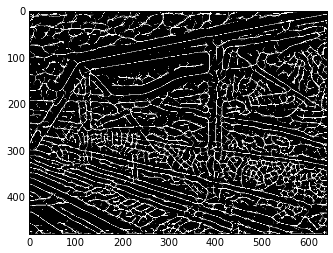

In [55]:
imshow(nonmaxsup(mag))

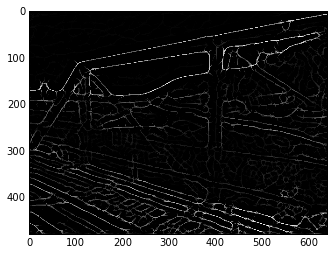

In [110]:
# plot of localized edges and their strengths
edges = where(nonmaxsup(mag),mag,0.0)
imshow(edges)



From among these, we now would like to select the strongest edges, since those are the most likely not due to noise.



0.0156960021948


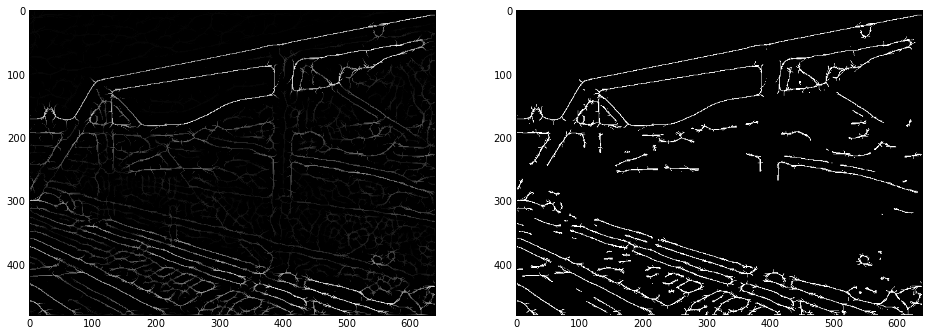

In [99]:
thr = stats.scoreatpercentile(edges[edges>0].ravel(),70)
print thr
imrow(edges,edges>thr)

We see that there is a problem with this approach: edges get broken up.

That is, along a strong edge, temporarily, the gradient magnitude falls below a threshold and a few pixels get removed.

We can avoid this problem with _hysteresis thresholding_.

Hysteresis thresholding first finds all edges with a low threshold, then keeps only those _connected edges_ that contain some edge pixels with values above a high threshold. In different words, edges along which the gradient is low everywhere are removed.

This is a heuristic, albeit a common one. It's one of the main steps of the _Canny edge detector_.

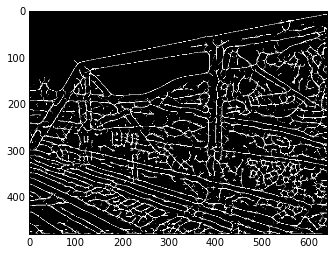

In [112]:
# compute low threshold
from scipy.ndimage import measurements
thr = stats.scoreatpercentile(edges[edges>0].ravel(),20)
bedges = 1*(edges>thr)
imshow(bedges)

The next step is a _labeling operation_. 

Labeling takes a binary image, looks for the _connected components_ and assigns a different integer to each connected component.

2607


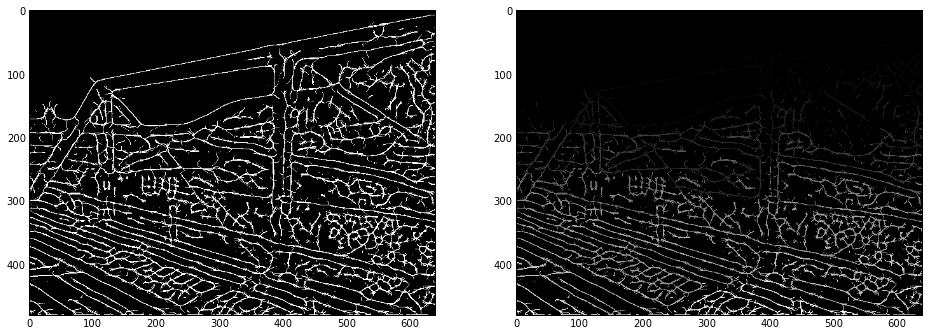

In [113]:
# binary edge labeling
labels,n = measurements.label(edges>thr)
print n
imrow(bedges,labels)

There are a number of measurement operations involving labels.

Labeled maximum computes, for each different label in the `labels` array, the maximum over all pixels with that label.



In [115]:
emax = measurements.maximum(edges,labels=labels,index=arange(n+1))
print emax.shape,emax

(2608,) [ 0.0024222   0.00407753  0.05439453 ...,  0.02991969  0.02803233
  0.00493227]


We now compute a high threshold, and then compute a binary array indicating whether the maximum of that component is above the high threshold.



In [117]:
hithr = stats.scoreatpercentile(edges[edges>0].ravel(),80)
eselect = emax>hithr

Finally, we subscript the indicator array `eselect` with the label array, giving the final output image.

This is an unusual subscripting operation, since we are subscripting a 1D array with a 2D array, yielding another 2D array.



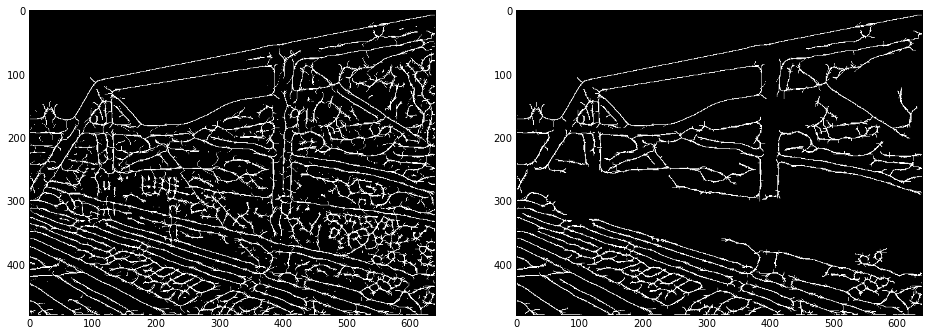

In [118]:
hystthreshold = eselect[labels]
imrow(bedges,hystthreshold)

Laplace Filter
--------------

There is a second derivative filter that is quite important in practice, the Laplace filter.

It is the discrete analog of second partial derivatives:

$\frac{\partial^2 I}{\partial x^2}+\frac{\partial^2 I}{\partial y^2}$

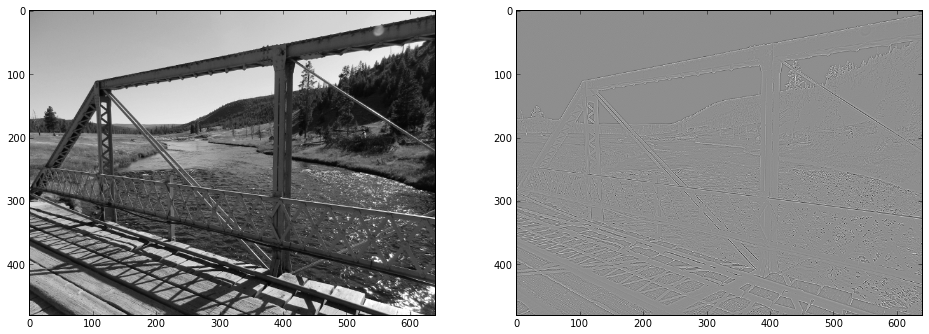

In [56]:
lap = filters.laplace(image)
imrow(image,lap)

This too is a linear filter, and we can look at its impulse response.

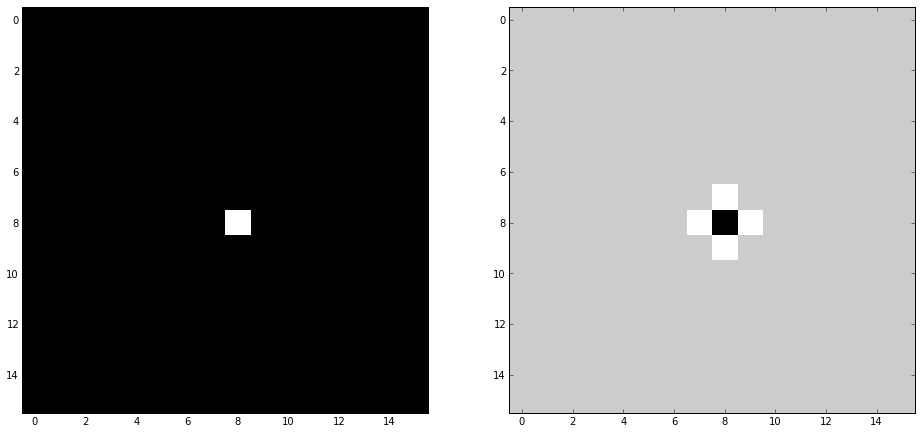

In [57]:
lap = filters.laplace(impulse)
imrow(impulse[24:40,24:40],lap[24:40,24:40],interpolation='nearest')

If we apply the Laplace filter to an image, we get "two responses" for every edge.

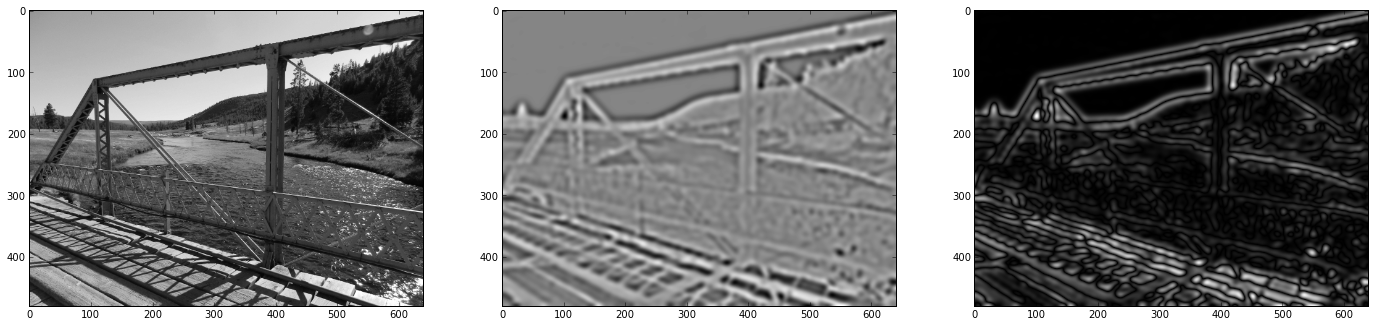

In [58]:
lap = filters.gaussian_laplace(image,5.0)
imrow(image,lap,abs(lap))

In fact, the Laplace filter is better thought of as a "blob detector",
and what matters about it is primarily its sign.

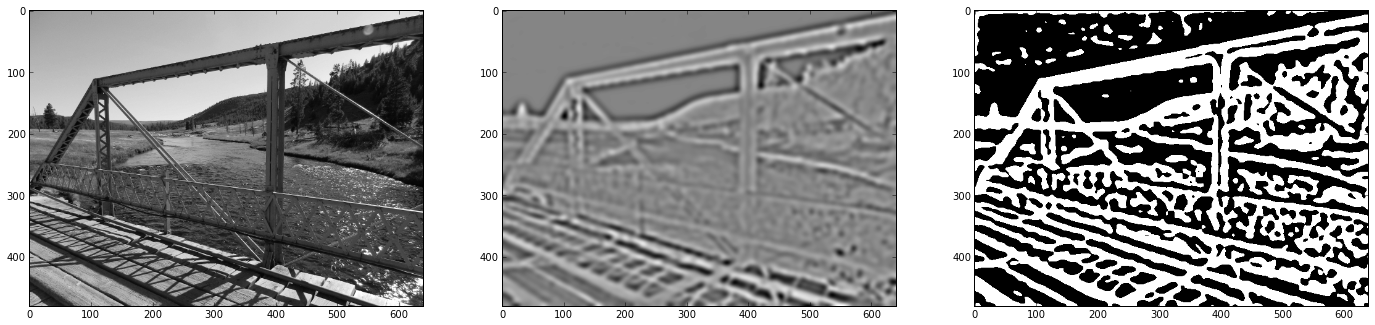

In [59]:
lap = filters.gaussian_laplace(image,5.0)
imrow(image,lap,lap>0)

Actually, it is useful to threshold slightly differently.

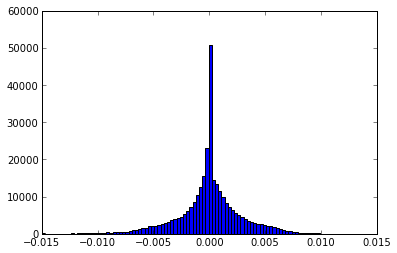

In [60]:
_=hist(lap.ravel(),bins=100)

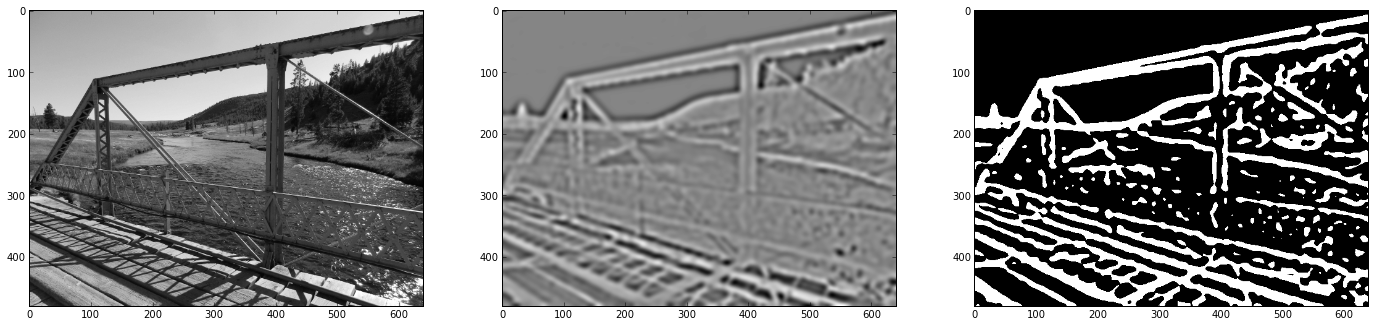

In [61]:
imrow(image,lap,lap>0.001)